In [3]:
import deepchem as dc
from openpom.feat.graph_featurizer import GraphFeaturizer, GraphConvConstants
from openpom.utils.data_utils import get_class_imbalance_ratio, IterativeStratifiedSplitter
from openpom.models.mpnn_pom import MPNNPOMModel
from datetime import datetime
from tqdm import tqdm
import torch
import numpy as np
from sklearn.metrics import roc_auc_score
import pandas as pd
import pubchempy as pcp
import matplotlib.pyplot as plt
import os

2025-02-22 11:31:43.163647: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-22 11:31:43.317855: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-22 11:31:43.495638: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740220303.668831  421752 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740220303.722678  421752 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been regist

Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


/home/colin/anaconda3/envs/open_test/lib/python3.9/site-packages/torchvision-0.15.2-py3.9-linux-x86_64.egg/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/colin/anaconda3/envs/open_test/lib/python3.9/site-packages/torchvision-0.15.2-py3.9-linux-x86_64.egg/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major b

save train and test splits

load splits

set parameters

In [16]:
from deepchem.metrics import Metric
from deepchem import metrics
train_ratios = get_class_imbalance_ratio(train_dataset)
assert len(train_ratios) == n_tasks

# learning_rate = 0.001
learning_rate = dc.models.optimizers.ExponentialDecay(initial_rate=0.001, decay_rate=0.5, decay_steps=32*20, staircase=True)

metric = Metric(metrics.roc_auc_score)

metrics_plu = [Metric(dc.metrics.accuracy_score), Metric(metrics.roc_auc_score), Metric(metrics.jaccard_score), Metric(metrics.f1_score)]

# run this cell if detailed log is needed

import logging

logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)

In [4]:
# no of models in the ensemble
n_layer = 5
n_models = 1

# no of epochs each model is trained for
nb_epoch = 30

Get test score from the ensemble

## Incorporation de la structure hiérarchique des odeurs
on utilise la bibliothéque rdflib pour les odeurs.

On transforme les CAS en smiles

In [7]:
df_od = pd.read_csv('Mol_odeur.csv')
TASKS = list(df_od.columns)
TASKS.remove("Smiles")
TASKS.remove("CAS")
n_tasks = len(TASKS)

dans les labels il n'y a pas que des odeurs mais aussi d'autres éléments qui possède des odeurs

Avant de travailler sur la Strucure hiérachique on tout d'abord donné l'ensemble des donné pour avoir un point de comparaison

de façon harbitraire on va définir le nombre de couche à 3

In [10]:
from deepchem.metrics import Metric
from deepchem import metrics
input_file = 'Mol_odeur.csv' # or new downloaded file path

# # get dataset

featurizer = GraphFeaturizer()
smiles_field = 'Smiles'
loader = dc.data.CSVLoader(tasks=TASKS,
                feature_field=smiles_field,
                featurizer=featurizer)

dataset = loader.create_dataset(inputs=[input_file])
n_tasks = len(dataset.tasks)

# # get train valid test splits
splitter = IterativeStratifiedSplitter(order=2)
train_dataset, test_dataset = splitter.train_test_split(dataset, frac_train=0.8)

train_ratios = get_class_imbalance_ratio(train_dataset)
assert len(train_ratios) == n_tasks

print("train_dataset: ", len(train_dataset))
print("test_dataset: ", len(test_dataset))

train_dataset:  2957
test_dataset:  780


In [12]:
n_models=5
learning_rate = 0.001
nb_epoch=30
Models=[]

In [17]:
for i in tqdm(range(n_models)):
    model_sketch = MPNNPOMModel(n_tasks = n_tasks,
                            batch_size=128,
                            learning_rate=learning_rate,
                            class_imbalance_ratio = train_ratios,
                            loss_aggr_type = 'sum',
                            node_out_feats = 100,
                            edge_hidden_feats = 75,
                            edge_out_feats = 100,
                            num_step_message_passing = 3,
                            mpnn_residual = True,
                            message_aggregator_type = 'sum',
                            mode = 'classification',
                            number_atom_features = GraphConvConstants.ATOM_FDIM,
                            number_bond_features = GraphConvConstants.BOND_FDIM,
                            n_classes = 1,
                            readout_type = 'set2set',
                            num_step_set2set = 3,
                            num_layer_set2set = 2,
                            ffn_hidden_list= [392, 392],
                            ffn_embeddings = 256,
                            ffn_activation = 'relu',
                            ffn_dropout_p = 0.12,
                            ffn_dropout_at_input_no_act = False,
                            weight_decay = 1e-5,
                            self_loop = False,
                            optimizer_name = 'adam',
                            log_frequency = 32,
                            model_dir = f'./sketchOscent/model_sans_hier/model_{i}',
                            device_name='cpu')

    start_time = datetime.now()
    print("time start")
    
    # fit model
    loss = model_sketch.fit(
          train_dataset,
          nb_epoch=nb_epoch,
          max_checkpoints_to_keep=1,
          deterministic=False,
          restore=False)
    print("time end")
    end_time = datetime.now()
    
    train_scores = model_sketch.evaluate(train_dataset, metrics_plu)
    test_scores = model_sketch.evaluate(test_dataset, metrics_plu)
    print(f"loss = {loss}; train_scores = {train_scores}; test_scores = {test_scores}; time_taken = {str(end_time-start_time)}")
    model_sketch.save_checkpoint() # saves final checkpoint => `checkpoint2.pt`
    Models.append(model_sketch)
    del model_sketch
    torch.cuda.empty_cache()

  0%|                                                     | 0/5 [00:00<?, ?it/s]

time start
time end


 20%|████████▏                                | 1/5 [22:33<1:30:13, 1353.37s/it]

loss = 2.3867602348327637; train_scores = {'accuracy_score': 0.9627836386581654, 'roc_auc_score': 0.9180220921972336, 'jaccard_score': 0.19690993926497874, 'f1_score': 0.3034415289764948}; test_scores = {'accuracy_score': 0.9593079007713154, 'roc_auc_score': 0.895197010736636, 'jaccard_score': 0.1920556146808952, 'f1_score': 0.28825494104230925}; time_taken = 0:22:07.313273
time start
time end


 40%|████████████████▍                        | 2/5 [46:23<1:09:55, 1398.47s/it]

loss = 2.419536590576172; train_scores = {'accuracy_score': 0.963880663493818, 'roc_auc_score': 0.9190194769672766, 'jaccard_score': 0.1975844457474392, 'f1_score': 0.3031698756090737}; test_scores = {'accuracy_score': 0.9602251407129455, 'roc_auc_score': 0.8957760414325863, 'jaccard_score': 0.19839402530704003, 'f1_score': 0.29810423392194685}; time_taken = 0:23:22.788283
time start
time end


 60%|████████████████████████▌                | 3/5 [1:12:04<48:47, 1463.80s/it]

loss = 2.4099910259246826; train_scores = {'accuracy_score': 0.9653241172249397, 'roc_auc_score': 0.9211071669347789, 'jaccard_score': 0.20213760747427686, 'f1_score': 0.309089258013818}; test_scores = {'accuracy_score': 0.9615593079007713, 'roc_auc_score': 0.8995402937395041, 'jaccard_score': 0.20232268945002105, 'f1_score': 0.30290444065004446}; time_taken = 0:25:16.740070
time start
time end


 80%|████████████████████████████████▊        | 4/5 [1:35:23<23:57, 1437.85s/it]

loss = 2.3873844146728516; train_scores = {'accuracy_score': 0.9642875799742102, 'roc_auc_score': 0.9218172219161626, 'jaccard_score': 0.21157023587335388, 'f1_score': 0.32287348729571425}; test_scores = {'accuracy_score': 0.9597977902855951, 'roc_auc_score': 0.8970494714407498, 'jaccard_score': 0.19933354237718443, 'f1_score': 0.2976481323472709}; time_taken = 0:22:54.609656
time start
time end


100%|█████████████████████████████████████████| 5/5 [1:58:45<00:00, 1425.12s/it]

loss = 2.411137342453003; train_scores = {'accuracy_score': 0.9643398192520984, 'roc_auc_score': 0.9212614263459058, 'jaccard_score': 0.20105770578295057, 'f1_score': 0.30786629880835414}; test_scores = {'accuracy_score': 0.9608088388576193, 'roc_auc_score': 0.8974187600815726, 'jaccard_score': 0.18965774165620758, 'f1_score': 0.2835758254713209}; time_taken = 0:22:56.406349


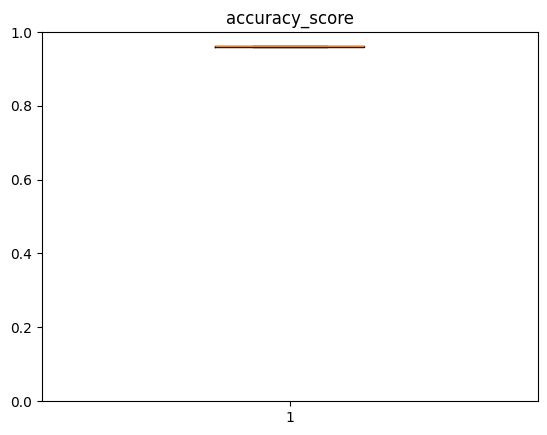

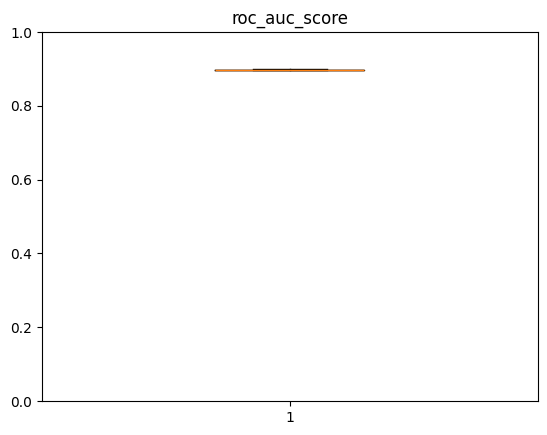

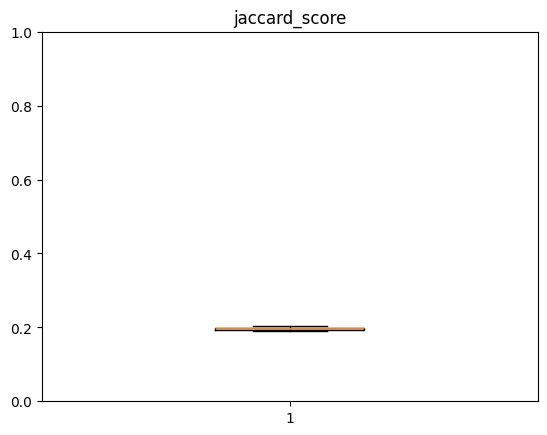

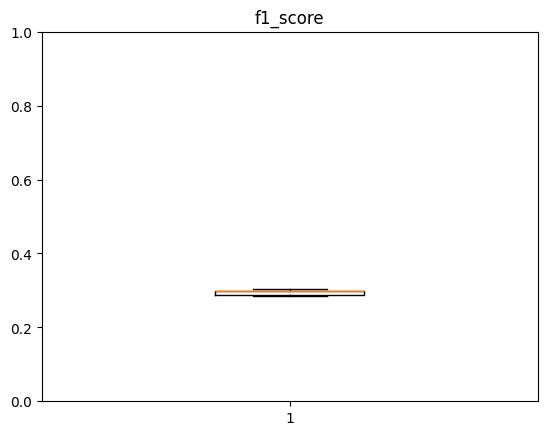

In [41]:
import os
scores = [model.evaluate(test_dataset, metrics_plu) for model in Models]
for metr in test_scores.keys():
    plt.boxplot([score[metr] for score in scores], widths=0.6)
    #plt.gca().xaxis.set_ticklabels([f"{dim}_layer" for dim in models_dict.keys()])
    plt.axis([0,2,0,1])
    plt.title(metr)
    save_path = f"./precision/base/"
    #os.makedirs(os.path.dirname(save_path), exist_ok=True)
    #plt.savefig(save_path+metr)
    plt.show()

In [61]:
def split_train_test(input_file, TASKS):
    featurizer = GraphFeaturizer()
    smiles_field = 'Smiles'
    loader = dc.data.CSVLoader(tasks=TASKS,
                    feature_field=smiles_field,
                    featurizer=featurizer)
    
    dataset = loader.create_dataset(inputs=[input_file])
    n_tasks = len(dataset.tasks)
    
    # # get train valid test splits
    splitter = IterativeStratifiedSplitter(order=2)
    train_dataset, test_dataset = splitter.train_test_split(dataset, frac_train=0.8)
    
    train_ratios = get_class_imbalance_ratio(train_dataset)
    assert len(train_ratios) == n_tasks
    return train_dataset, test_dataset, n_tasks, train_ratios

def train_mod(train_dataset, n_models, n_tasks, train_ratios, nb_couches, directory):
    Models_dict = []
    for i in tqdm(range(n_models)):
        model_sketch = MPNNPOMModel(n_tasks = n_tasks,
                                batch_size=128,
                                learning_rate=learning_rate,
                                class_imbalance_ratio = train_ratios,
                                loss_aggr_type = 'sum',
                                node_out_feats = 100,
                                edge_hidden_feats = 75,
                                edge_out_feats = 100,
                                num_step_message_passing = nb_couches,
                                mpnn_residual = True,
                                message_aggregator_type = 'sum',
                                mode = 'classification',
                                number_atom_features = GraphConvConstants.ATOM_FDIM,
                                number_bond_features = GraphConvConstants.BOND_FDIM,
                                n_classes = 1,
                                readout_type = 'set2set',
                                num_step_set2set = 3,
                                num_layer_set2set = 2,
                                ffn_hidden_list= [392, 392],
                                ffn_embeddings = 256,
                                ffn_activation = 'relu',
                                ffn_dropout_p = 0.12,
                                ffn_dropout_at_input_no_act = False,
                                weight_decay = 1e-5,
                                self_loop = False,
                                optimizer_name = 'adam',
                                log_frequency = 32,
                                model_dir = f'{directory}/model_{i}',
                                device_name='cpu')
    
        start_time = datetime.now()
        print("time start")
        
        # fit model
        loss = model_sketch.fit(
              train_dataset,
              nb_epoch=nb_epoch,
              max_checkpoints_to_keep=1,
              deterministic=False,
              restore=False)
        print("time end")
        end_time = datetime.now()
        
        train_scores = model_sketch.evaluate(train_dataset, metrics_plu)
        print(f"loss = {loss}; train_scores = {train_scores}; time_taken = {str(end_time-start_time)}")
        model_sketch.save_checkpoint() # saves final checkpoint => `checkpoint2.pt`
        Models_dict.append(model_sketch)
        del model_sketch
        torch.cuda.empty_cache()
    return Models_dict

In [28]:
train_wth_dupl, test_wth_dupl, n_tasks, train_wth_dupl_ratios = split_train_test("Mol_odeur_sans_doublons.csv", TASKS=TASKS)
Models_wth_dupl = train_mod(train_wth_dupl,n_models=5, n_tasks=n_tasks, train_ratios=train_wth_dupl_ratios, nb_couches=3, directory="./models_wth_dupl")

  0%|                                                     | 0/5 [00:00<?, ?it/s]

time start
time end


 20%|████████▏                                | 1/5 [21:07<1:24:29, 1267.37s/it]

loss = 2.5132312774658203; train_scores = {'accuracy_score': 0.9658782065893986, 'roc_auc_score': 0.9184232159338561, 'jaccard_score': 0.19424396852056566, 'f1_score': 0.2966684558362546}; time_taken = 0:20:50.179283
time start
time end


 40%|████████████████▍                        | 2/5 [41:11<1:01:30, 1230.20s/it]

loss = 2.5317264556884767; train_scores = {'accuracy_score': 0.9635841326062434, 'roc_auc_score': 0.9192751843439102, 'jaccard_score': 0.19843994988326316, 'f1_score': 0.3057269557128689}; time_taken = 0:19:48.221674
time start
time end


 60%|████████████████████████▌                | 3/5 [1:01:04<40:26, 1213.01s/it]

loss = 2.4803754806518556; train_scores = {'accuracy_score': 0.9669010421232895, 'roc_auc_score': 0.9227643647359843, 'jaccard_score': 0.20225601002431598, 'f1_score': 0.30765432939076437}; time_taken = 0:19:35.932435
time start
time end


 80%|████████████████████████████████▊        | 4/5 [1:21:22<20:14, 1214.95s/it]

loss = 2.520633506774902; train_scores = {'accuracy_score': 0.9659629558193497, 'roc_auc_score': 0.9199286526765484, 'jaccard_score': 0.1978909876886305, 'f1_score': 0.3027718313119547}; time_taken = 0:19:59.972275
time start
time end


100%|█████████████████████████████████████████| 5/5 [1:53:51<00:00, 1366.33s/it]

loss = 2.426164436340332; train_scores = {'accuracy_score': 0.9655859678654299, 'roc_auc_score': 0.9262818098282919, 'jaccard_score': 0.21841528227409265, 'f1_score': 0.3311719069171888}; time_taken = 0:32:02.043848


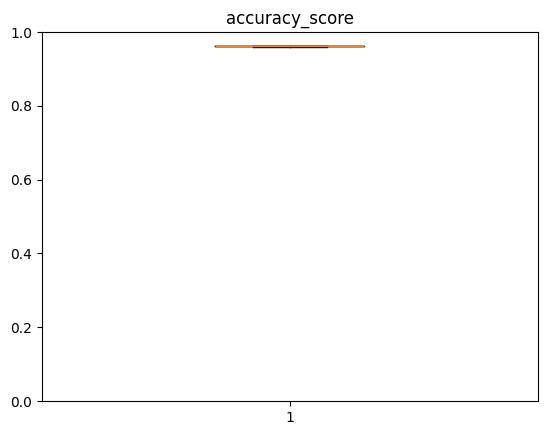

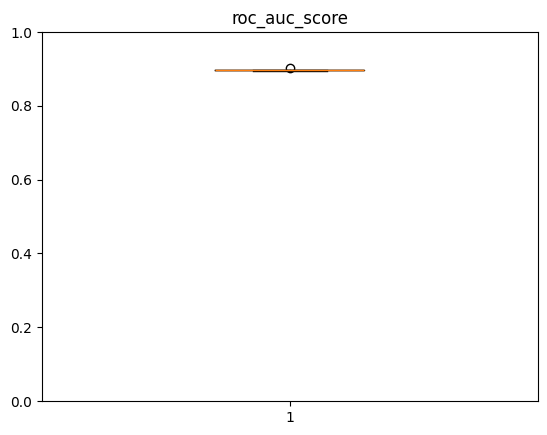

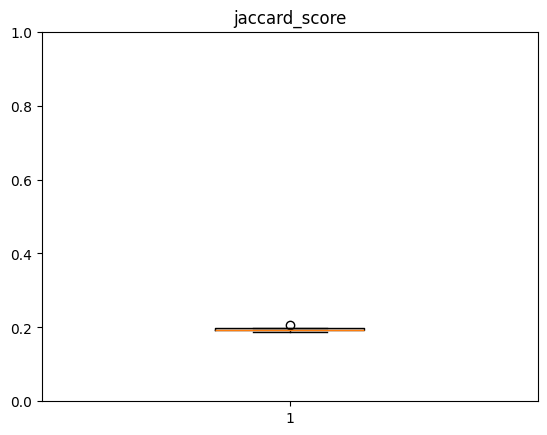

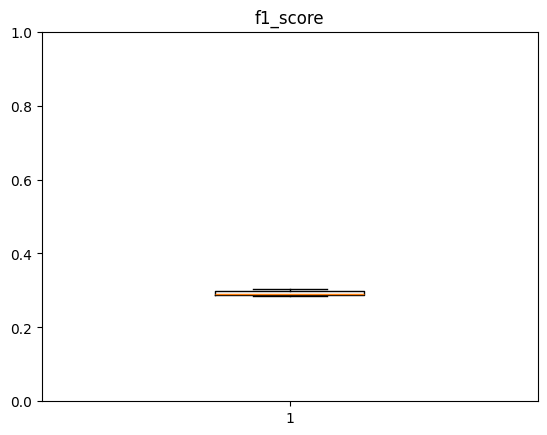

In [42]:
scores = [model.evaluate(test_dataset, metrics_plu) for model in Models_wth_dupl]
for metr in test_scores.keys():
    plt.boxplot([score[metr] for score in scores], widths=0.6)
    #plt.gca().xaxis.set_ticklabels([f"{dim}_layer" for dim in models_dict.keys()])
    plt.axis([0,2,0,1])
    plt.title(metr)
    plt.show()
    """
    save_path = f"./precision/without_duplicate/"
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path+metr)
    plt.close()"""

In [38]:
train_wth_zeros, test_wth_zeros, n_tasks, train_wth_zeros_ratios = split_train_test("Mol_odeur_sans_zeros.csv",TASKS=TASKS)
Models_wth_zeros = train_mod(train_wth_dupl,n_models=5, n_tasks=n_tasks, train_ratios=train_wth_dupl_ratios, nb_couches=3, directory="./models_wth_zeros")


  0%|                                                     | 0/5 [00:00<?, ?it/s]

time start
time end


 20%|████████▏                                | 1/5 [51:38<3:26:33, 3098.38s/it]

loss = 2.481637382507324; train_scores = {'accuracy_score': 0.9664393049394189, 'roc_auc_score': 0.9200469986430077, 'jaccard_score': 0.19070889860657625, 'f1_score': 0.2914402437713763}; time_taken = 0:51:10.587550
time start
time end


 40%|███████████████▌                       | 2/5 [1:44:52<2:37:44, 3154.84s/it]

loss = 2.553824806213379; train_scores = {'accuracy_score': 0.9645952785911756, 'roc_auc_score': 0.9182236952051416, 'jaccard_score': 0.1912706128777128, 'f1_score': 0.29312720294780104}; time_taken = 0:52:43.717183
time start
time end


 60%|███████████████████████▍               | 3/5 [2:21:33<1:30:38, 2719.18s/it]

loss = 2.519260597229004; train_scores = {'accuracy_score': 0.9642767383820496, 'roc_auc_score': 0.920005048723855, 'jaccard_score': 0.20721740272486486, 'f1_score': 0.31709696311971214}; time_taken = 0:36:10.171527
time start
time end


 80%|████████████████████████████████▊        | 4/5 [2:58:42<42:05, 2525.72s/it]

loss = 2.451963424682617; train_scores = {'accuracy_score': 0.9651417650049972, 'roc_auc_score': 0.9253314700770582, 'jaccard_score': 0.21017030455423916, 'f1_score': 0.32124212773843763}; time_taken = 0:36:40.118853
time start
time end


100%|█████████████████████████████████████████| 5/5 [3:39:43<00:00, 2636.80s/it]

loss = 2.4682680130004884; train_scores = {'accuracy_score': 0.9656414932229841, 'roc_auc_score': 0.9201288610407543, 'jaccard_score': 0.1904439915401816, 'f1_score': 0.29146989289150055}; time_taken = 0:40:30.980952


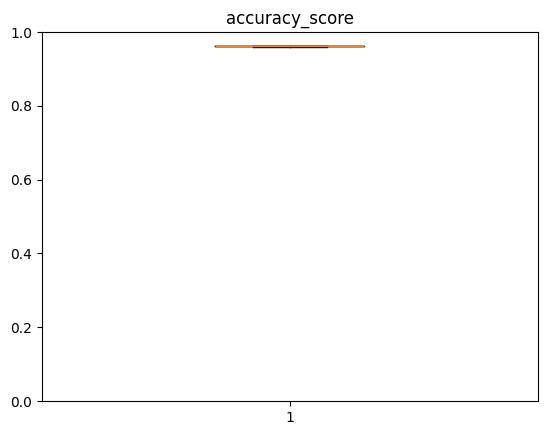

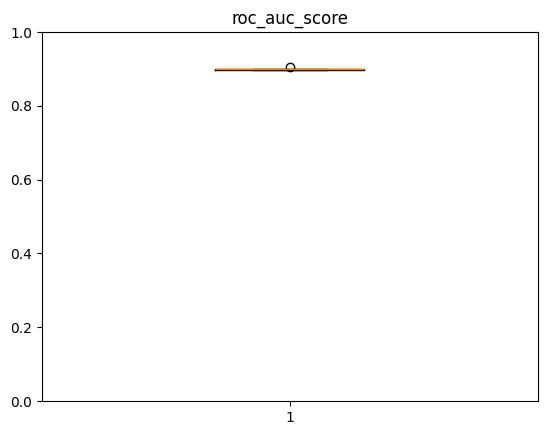

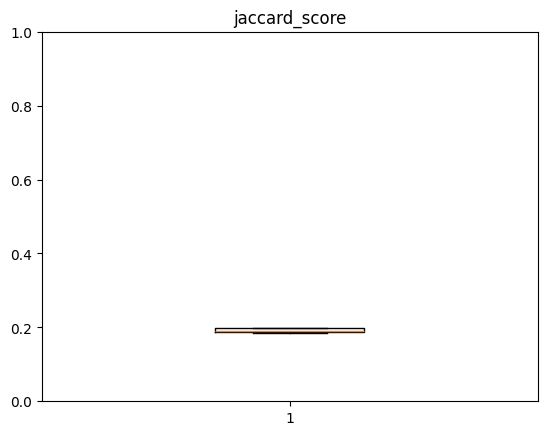

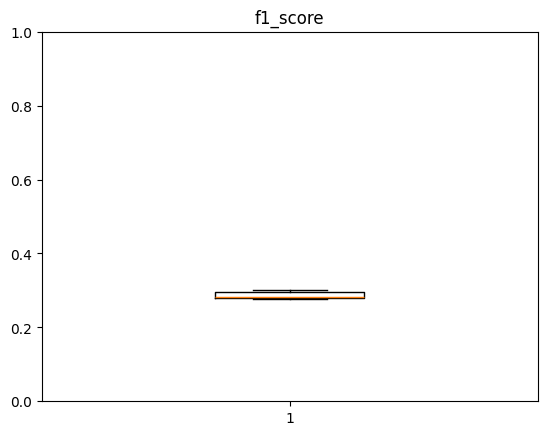

In [40]:
scores = [model.evaluate(test_dataset, metrics_plu) for model in Models_wth_zeros]
for metr in test_scores.keys():
    plt.boxplot([score[metr] for score in scores], widths=0.6)
    #plt.gca().xaxis.set_ticklabels([f"{dim}_layer" for dim in models_dict.keys()])
    plt.axis([0,2,0,1])
    plt.title(metr)
    plt.show()
    """
    save_path = f"./precision/without_zeros/"
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path+metr)
    plt.close()"""

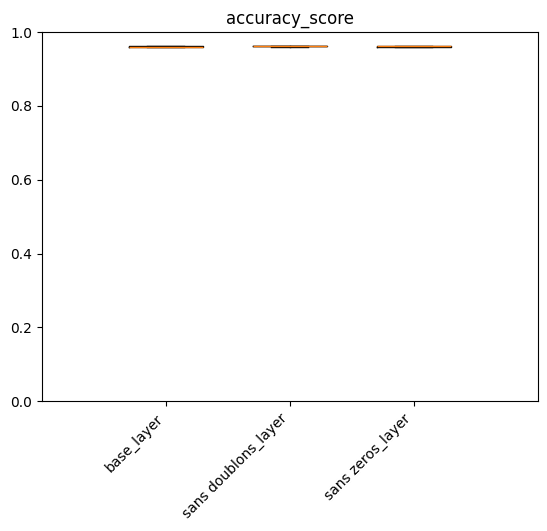

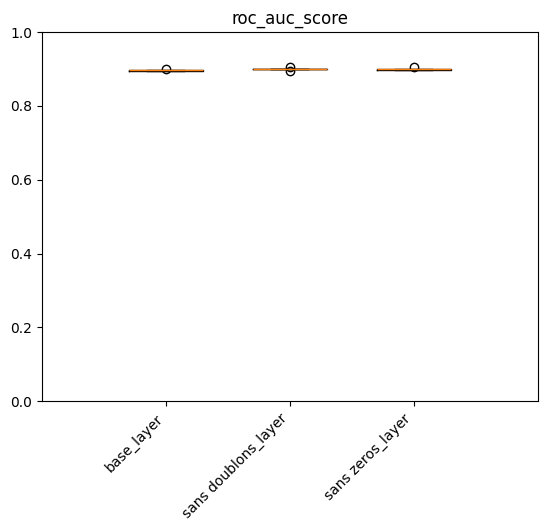

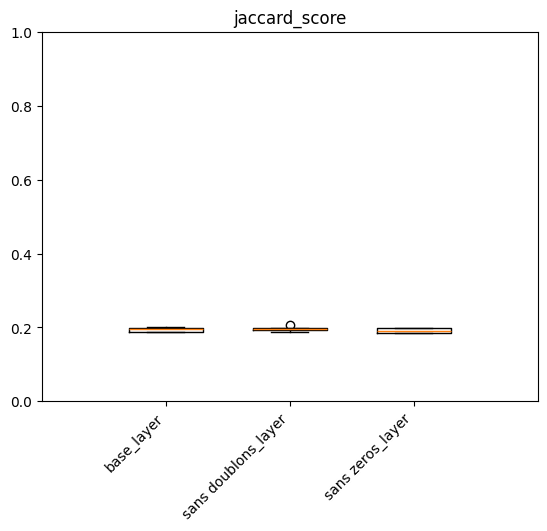

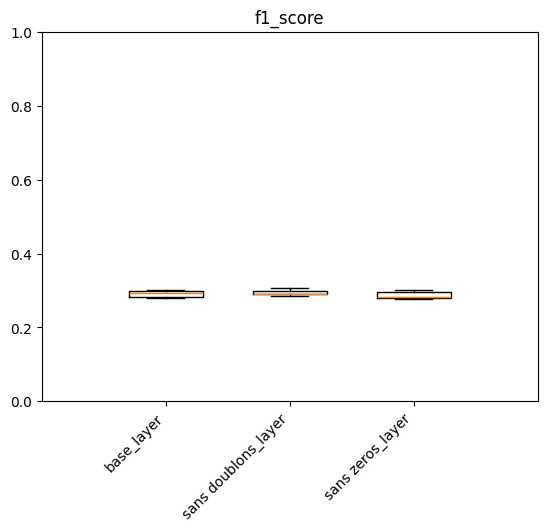

In [66]:
scores3 = [model.evaluate(test_dataset, metrics_plu) for model in Models_wth_zeros]
scores2 = [model.evaluate(test_wth_dupl, metrics_plu) for model in Models_wth_dupl]
scores1 = [model.evaluate(test_wth_zeros, metrics_plu) for model in Models]
dict_resuslt = {'base': scores1, 'sans doublons': scores2, 'sans zeros': scores3}
for metr in test_scores.keys():
    i=0
    for (dim,scores) in dict_resuslt.items():
        i+=1        
        plt.boxplot([score[metr] for score in scores], positions=[i], widths=0.6)
    plt.gca().xaxis.set_ticklabels([f"{dim}_layer" for dim in dict_resuslt.keys()])
    plt.axis([0,4,0,1])
    plt.xticks(rotation=45, ha="right") 
    plt.title(metr)
    plt.show()

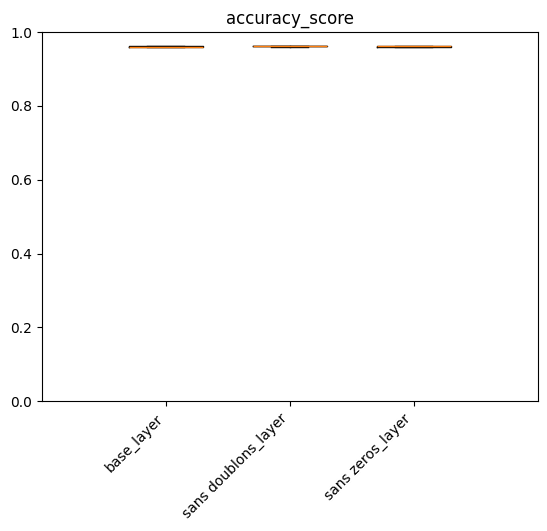

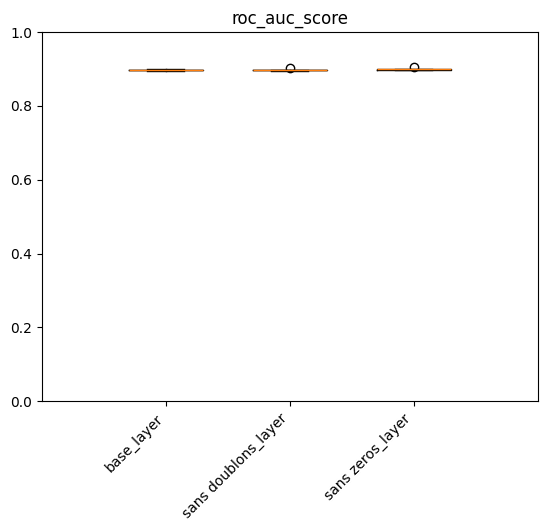

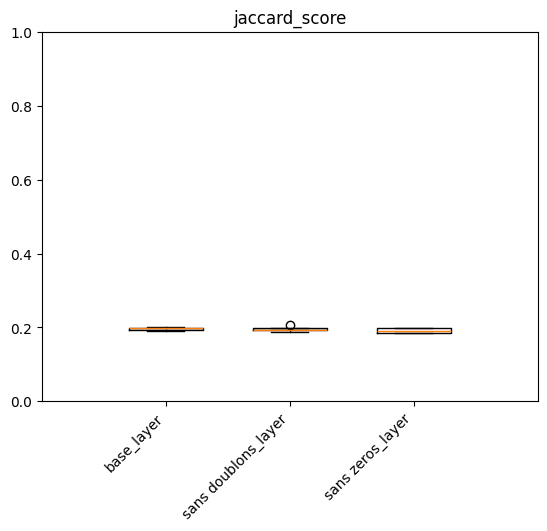

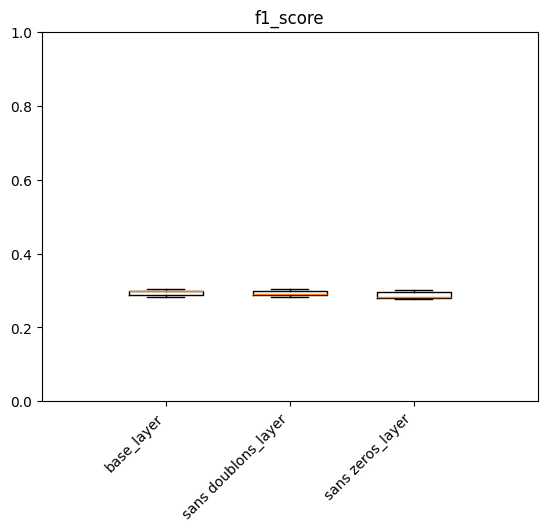

In [50]:
for metr in test_scores.keys():
    i=0
    for (dim,scores) in dict_resuslt.items():
        i+=1        
        plt.boxplot([score[metr] for score in scores], positions=[i], widths=0.6)
    plt.gca().xaxis.set_ticklabels([f"{dim}_layer" for dim in dict_resuslt.keys()])
    plt.axis([0,4,0,1])
    plt.xticks(rotation=45, ha="right") 
    plt.title(metr)
    plt.show()

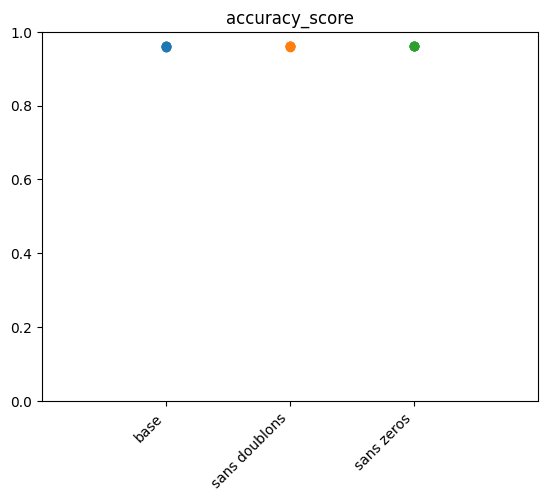

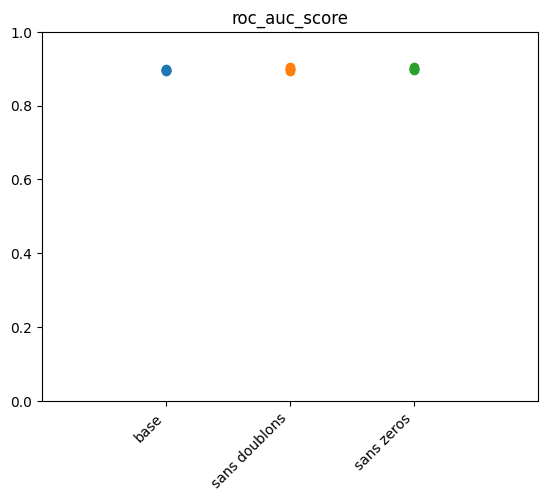

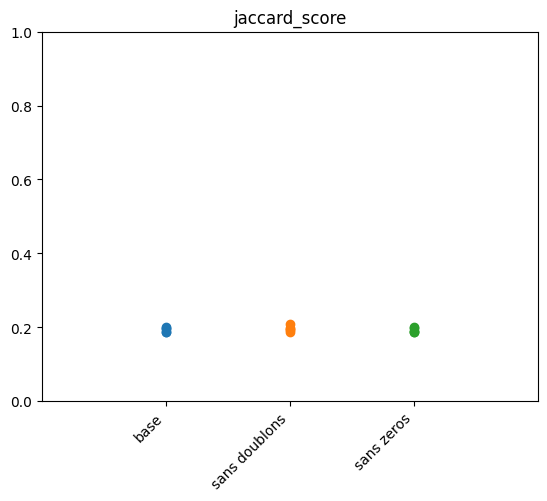

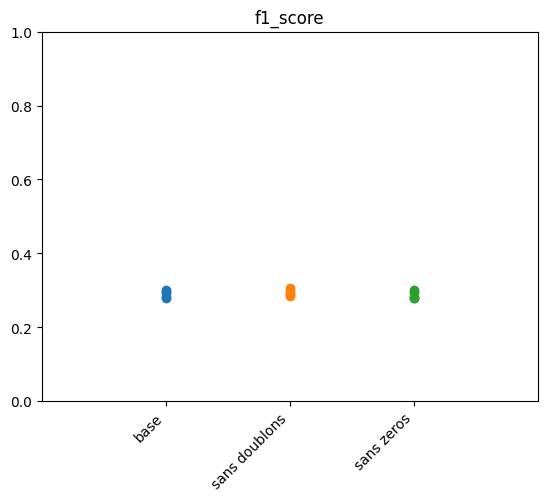

In [70]:
for metr in test_scores.keys():
    x_positions = []  # Stocker les positions des ticks
    labels = []  # Stocker les labels des ticks

    i = 1  # Commencer l'indexation des positions à 1
    for dim, scores in dict_resuslt.items():
        y_values = [score[metr] for score in scores]
        plt.scatter([i] * len(y_values), y_values)
        
        x_positions.append(i)  # Ajouter la position du tick
        labels.append(f"{dim}")  # Ajouter le label du tick
        
        i += 1  # Passer à la prochaine position
    
    plt.xticks(x_positions, labels, rotation=45, ha="right")  # Centrer les labels
    plt.axis([0, len(dict_resuslt) + 1, 0, 1])
    plt.title(metr)
    plt.show()
    """
    save_path = f"./precision/different_dataset/scatter/"
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path+metr)
    plt.close()
    """

### On supprime les odeurs qui ne sont pas des noeuds

In [63]:
df = pd.read_csv("Individual_label.csv")
TASKS_ind = list(df.columns)
TASKS_ind.remove("Smiles")
train_ind, test_ind, n_tasks_ind, train_ind_ratios = split_train_test("Individual_label.csv", TASKS=TASKS_ind)
Models_ind = train_mod(train_ind, n_models=5, n_tasks=n_tasks_ind, train_ratios=train_ind_ratios, nb_couches=3, directory="./models_individual/wth_zeros")


  0%|                                                     | 0/5 [00:00<?, ?it/s]

time start
time end


 20%|████████▏                                | 1/5 [21:36<1:26:24, 1296.19s/it]

loss = 0.9602038383483886; train_scores = {'accuracy_score': 0.9736844881424592, 'roc_auc_score': 0.9168299096399493, 'jaccard_score': 0.1374124770546234, 'f1_score': 0.2109355129800704}; time_taken = 0:21:20.371065
time start
time end


 40%|████████████████▍                        | 2/5 [47:20<1:12:06, 1442.24s/it]

loss = 0.9684452056884766; train_scores = {'accuracy_score': 0.9756625031648243, 'roc_auc_score': 0.9142804498598169, 'jaccard_score': 0.15029218380298304, 'f1_score': 0.23035847348475186}; time_taken = 0:24:07.877208
time start
time end


 60%|████████████████████████▌                | 3/5 [1:11:10<47:53, 1436.55s/it]

loss = 0.9305391311645508; train_scores = {'accuracy_score': 0.9770128280867584, 'roc_auc_score': 0.9275476123074051, 'jaccard_score': 0.15326589770254986, 'f1_score': 0.2331358946014663}; time_taken = 0:23:33.933061
time start
time end


 80%|████████████████████████████████▊        | 4/5 [1:32:23<22:52, 1372.15s/it]

loss = 0.9147181510925293; train_scores = {'accuracy_score': 0.9769917292598532, 'roc_auc_score': 0.9317494809041883, 'jaccard_score': 0.1685514133171176, 'f1_score': 0.254706711148096}; time_taken = 0:20:57.546038
time start
time end


100%|█████████████████████████████████████████| 5/5 [1:48:44<00:00, 1304.83s/it]

loss = 0.9910884857177734; train_scores = {'accuracy_score': 0.9745337159253945, 'roc_auc_score': 0.9175035421778643, 'jaccard_score': 0.14021722793434432, 'f1_score': 0.21598449965376165}; time_taken = 0:16:07.889240


In [71]:
train_ind_wtho_zeros, test_ind_wtho_zeros, n_tasks_ind, train_ind_wtho_ratios = split_train_test('Individual_label_wtho_zeros.csv',TASKS=TASKS_ind)
Models_ind_wtho_zeros = train_mod(train_ind_wtho_zeros, n_models=5, n_tasks=n_tasks_ind, train_ratios=train_ind_wtho_ratios, nb_couches=3, directory="./models_individual/wtho_zeros")


  0%|                                                     | 0/5 [00:00<?, ?it/s]

time start
time end


 20%|████████▍                                 | 1/5 [15:27<1:01:49, 927.39s/it]

loss = 1.1142770222255163; train_scores = {'accuracy_score': 0.9703805440171512, 'roc_auc_score': 0.9014049629322274, 'jaccard_score': 0.13930727461021503, 'f1_score': 0.211267387877167}; time_taken = 0:15:14.740679
time start
time end


 40%|█████████████████▏                         | 2/5 [33:05<50:13, 1004.54s/it]

loss = 1.0943191392081124; train_scores = {'accuracy_score': 0.9671043816159721, 'roc_auc_score': 0.9001195602314878, 'jaccard_score': 0.15944893905141108, 'f1_score': 0.24103921326433106}; time_taken = 0:17:19.549233
time start
time end


 60%|█████████████████████████▊                 | 3/5 [59:25<42:14, 1267.32s/it]

loss = 1.0940179143633162; train_scores = {'accuracy_score': 0.9647058823529413, 'roc_auc_score': 0.883899243485647, 'jaccard_score': 0.12797516731372188, 'f1_score': 0.1974393480666538}; time_taken = 0:26:00.895729
time start
time end


 80%|████████████████████████████████▊        | 4/5 [1:21:54<21:39, 1299.20s/it]

loss = 1.0811659267970495; train_scores = {'accuracy_score': 0.9668966903390057, 'roc_auc_score': 0.9025533031636206, 'jaccard_score': 0.1634875711383575, 'f1_score': 0.2453810580772334}; time_taken = 0:22:09.710766
time start
time end


100%|█████████████████████████████████████████| 5/5 [1:47:36<00:00, 1291.26s/it]

loss = 1.092644350869315; train_scores = {'accuracy_score': 0.9690205011389521, 'roc_auc_score': 0.903304837691023, 'jaccard_score': 0.15164349297788582, 'f1_score': 0.22844670240806841}; time_taken = 0:25:21.182851


In [99]:
dict_result_ind={"Odeurs_indiv_Av__0": [model.evaluate(test_ind, metrics_plu) for model in Models_ind],
                 "Odeurs_indiv_Sans__0": [model.evaluate(test_ind_wtho_zeros,metrics_plu) for model in Models_ind_wtho_zeros],
                "Toutes odeurs": scores3 }
for metr in test_scores.keys():
    x_positions = []  # Stocker les positions des ticks
    labels = []  # Stocker les labels des ticks

    i = 1  # Commencer l'indexation des positions à 1
    for dim, scores in dict_result_ind.items():
        y_values = [score[metr] for score in scores]
        plt.scatter([i] * len(y_values), y_values)
        
        x_positions.append(i)  # Ajouter la position du tick
        labels.append(f"{dim}")  # Ajouter le label du tick
        
        i += 1  # Passer à la prochaine position
    
    plt.xticks(x_positions, labels, rotation=25, ha="right")  # Centrer les labels
    plt.axis([0, len(dict_result_ind) + 1, 0, 1])
    plt.title(metr)
    
    save_path = f"./precision/hierarchie/scatter/"
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path+metr)
    plt.close()
    #plt.show()

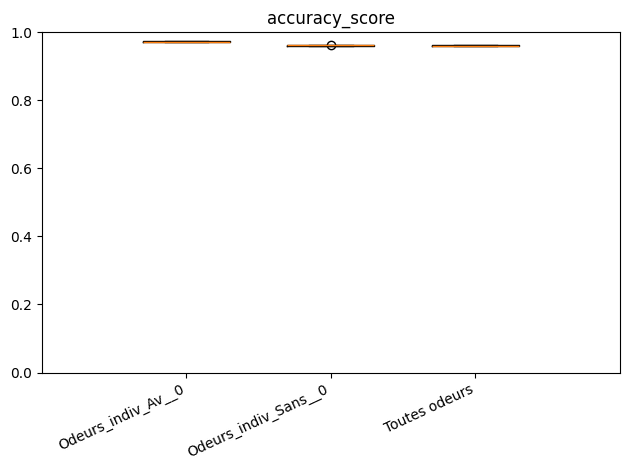

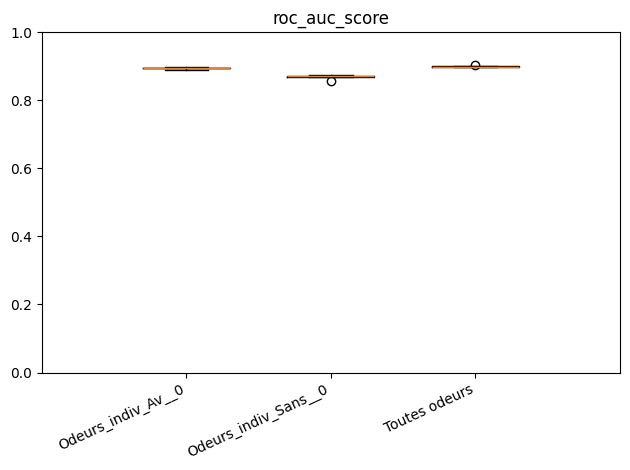

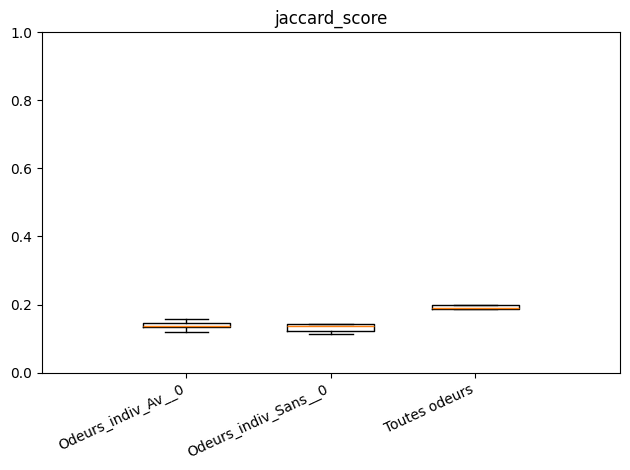

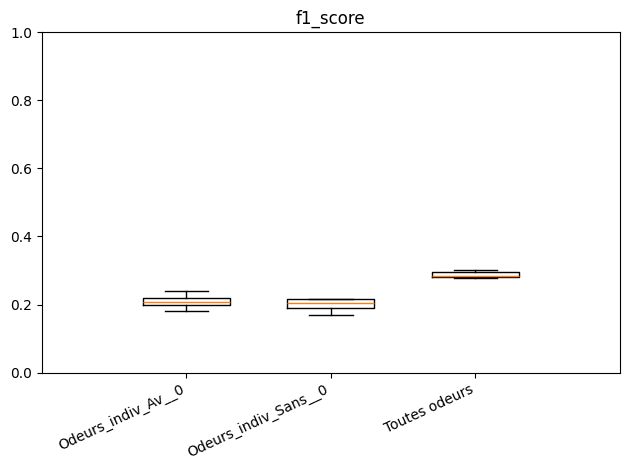

In [101]:
for metr in test_scores.keys():
    i=0
    for (dim,scores) in dict_result_ind.items():
        i+=1        
        plt.boxplot([score[metr] for score in scores], positions=[i], widths=0.6)
    plt.gca().xaxis.set_ticklabels([f"{dim}" for dim in dict_result_ind.keys()])
    plt.axis([0,4,0,1])
    plt.xticks(rotation=25, ha="right") 
    plt.title(metr)
    plt.tight_layout()
    
    save_path = f"./precision/hierarchie/boxplot/"
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path+metr)
    
    plt.show()

In [27]:
def guess(Dataset, Predictions, Not_individuals, graph_ttl=g):
    Predictions = (Predictions > 0.5).astype(int)
    nb_ligne, nb_columns = Predictions.shape
    New_Prediction = np.concatenate( (Predictions, np.zeros((nb_ligne, len(Not_individuals) ))), axis=1 )
    df_pred = pd.DataFrame(New_Prediction, columns=list(Dataset.tasks) + Not_individuals)
    for col in Dataset.tasks:
        quer = f""" 
        Select ?od_parent WHERE {{ 
            :{col} a ?od_parent . 
        }} """
        for res in g.query(quer):
            q = f"""
                Select ?parent WHERE{{ 
                    :{res[0].fragment} rdfs:subClassOf ?parent
                    }}
            """
            for res2 in g.query(q):
                if res2[0].fragment in Not_individuals:
                    df_pred[res2[0].fragment] = df_pred[res2[0].fragment] + df_pred[col]
    df_pred.applymap(lambda x: 1 if isinstance(x,int) and x>=1 else x )
    Smiles = pd.DataFrame({"smiles" : Dataset.ids}) 
    return pd.concat([Smiles,df_pred.reindex(sorted(df_pred.columns), axis=1)], axis=1)
                
    

In [45]:
def get_file(data_frame, file_name ='Mol_odeur.csv'):
    Labels = list(data_frame.columns)
    df = pd.read_csv(file_name, usecols=Labels)
    print(len(df.index) - len(df['smiles'].unique()))
    return df.filter(items=data_frame['smiles'], axis=0)
    